In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def exp_decay(z, A, B, C):
    return A * np.exp(-(z)/B) + C

In [3]:
folder = Path(r"/home/ricca/SMRR/garfield_tasks/Rx_build/Xenon")

In [4]:
data = {
    "Energy" : np.arange(1000, 25000, 500),
    "z" : [],
    "counts" : []
}

In [5]:
files = [f for f in folder.iterdir() if f.is_file()]

for f in files:
    temp = np.genfromtxt(f, delimiter='\t')
    mask = np.where(temp.T[1]==0)[0]
    data["z"].append(temp.T[4][mask]+0.29)
    data["counts"].append(len(np.unique(temp.T[0]))/5e4)

/tmp/ipykernel_164924/3026187430.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


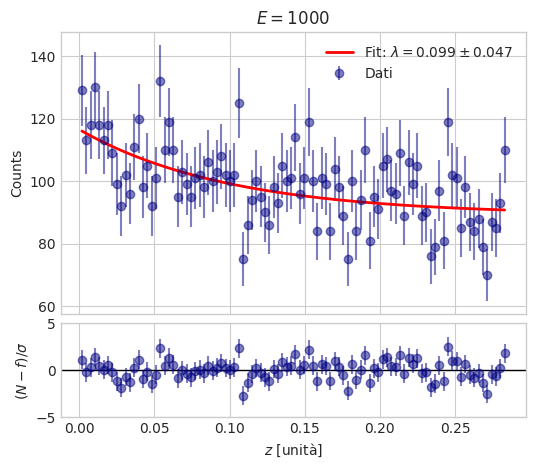

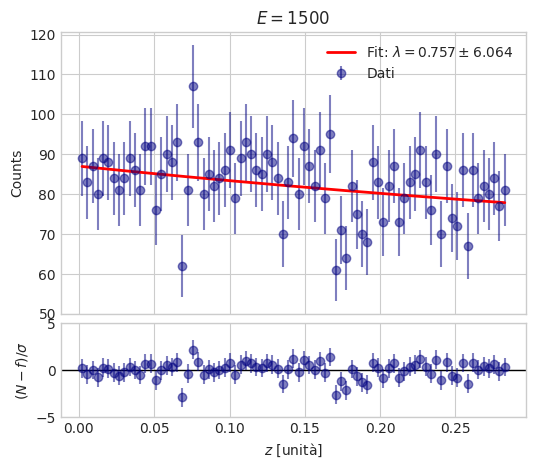

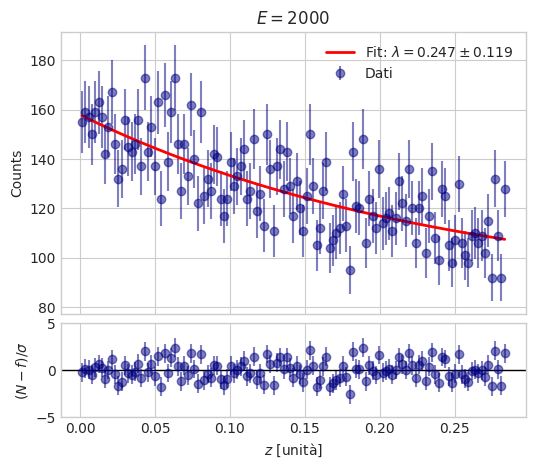

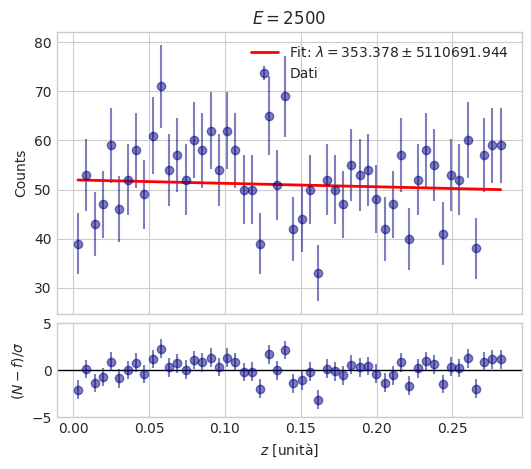

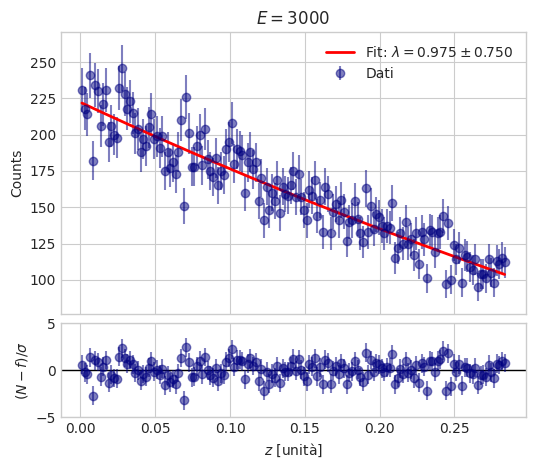

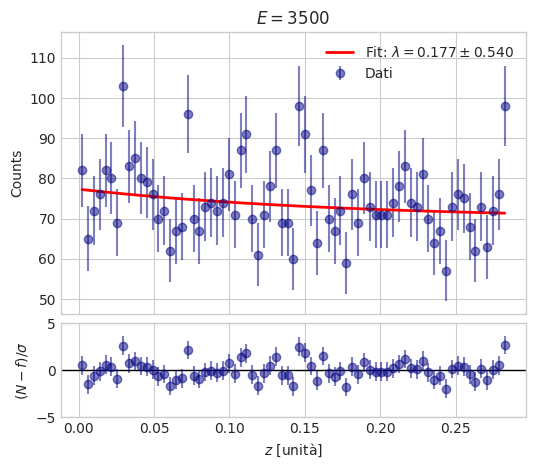

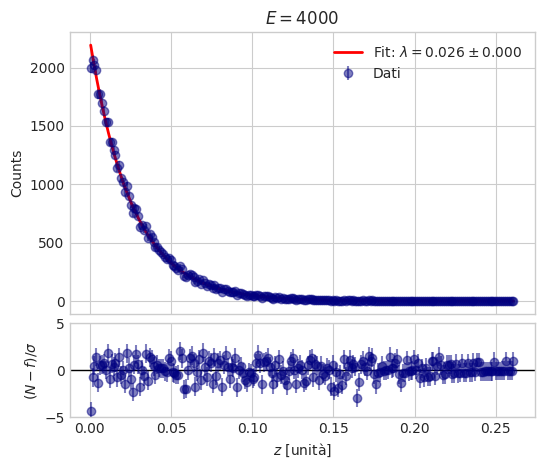

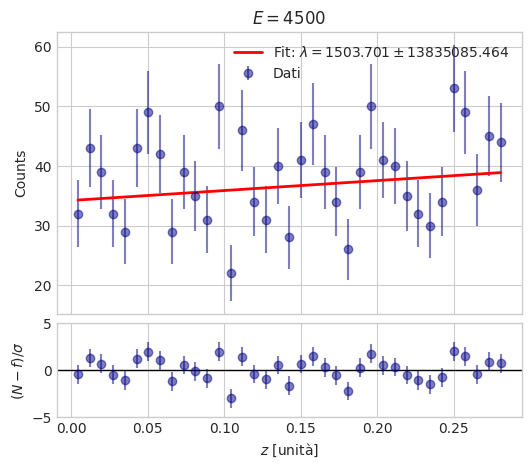

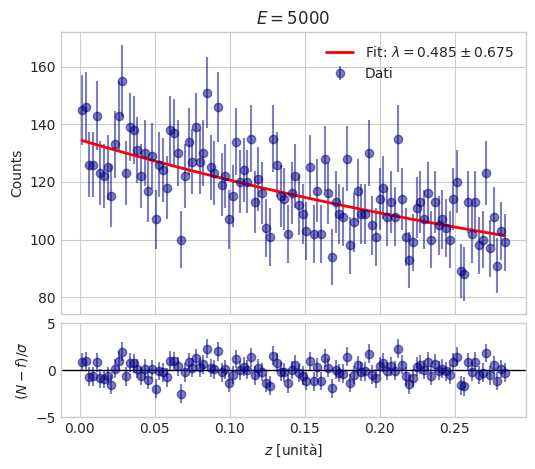

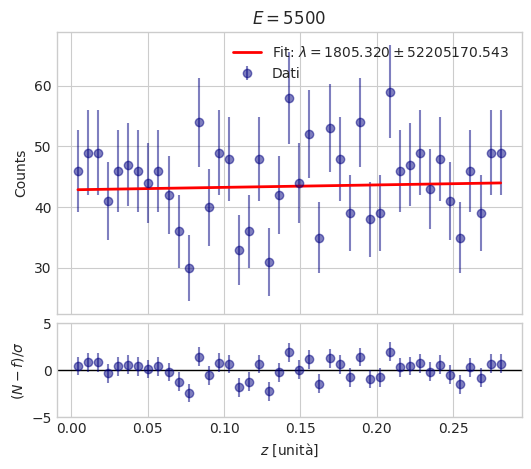

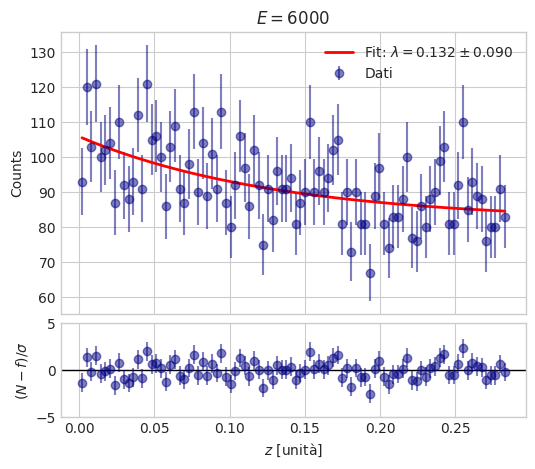

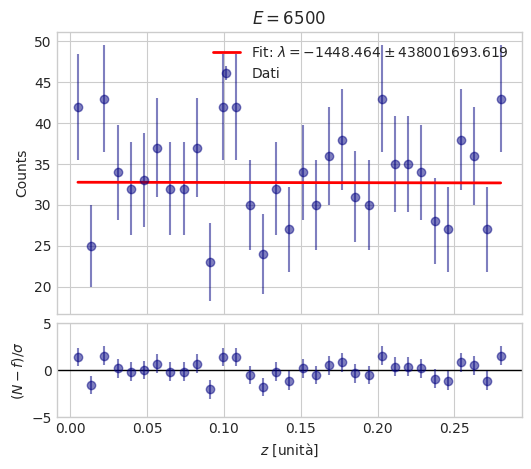

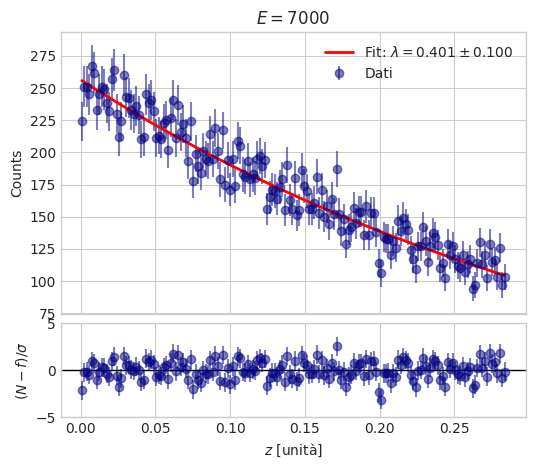

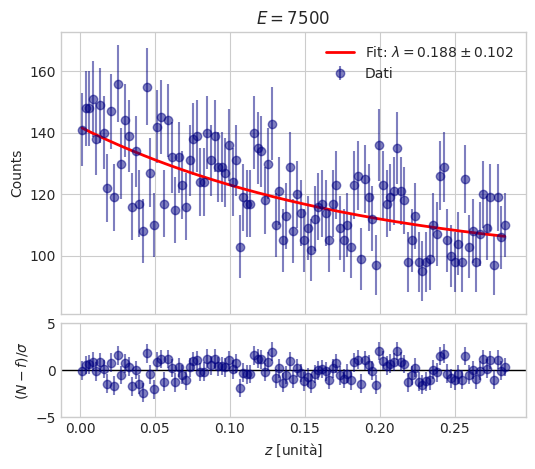

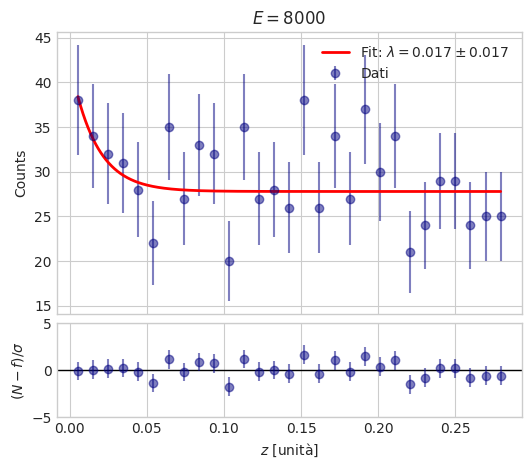

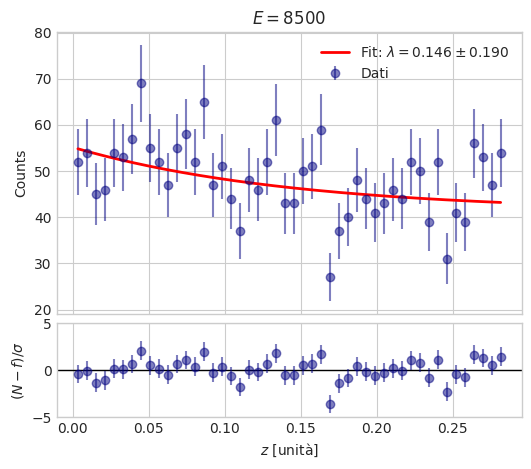

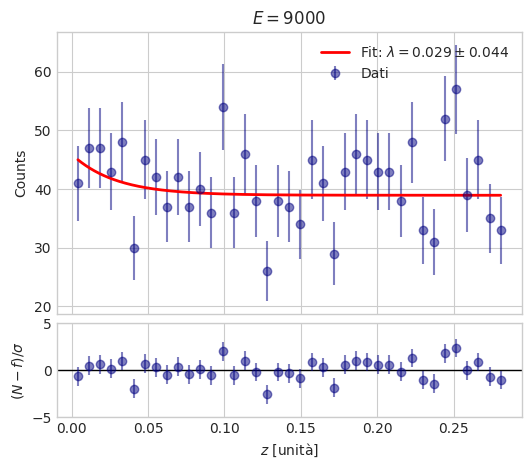

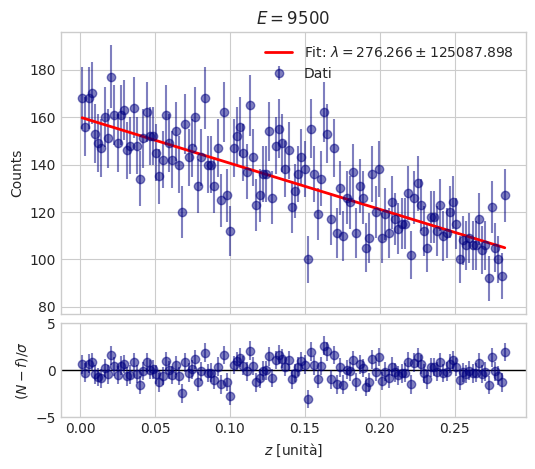

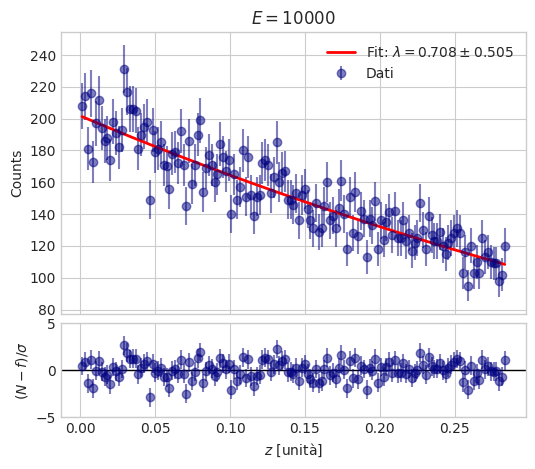

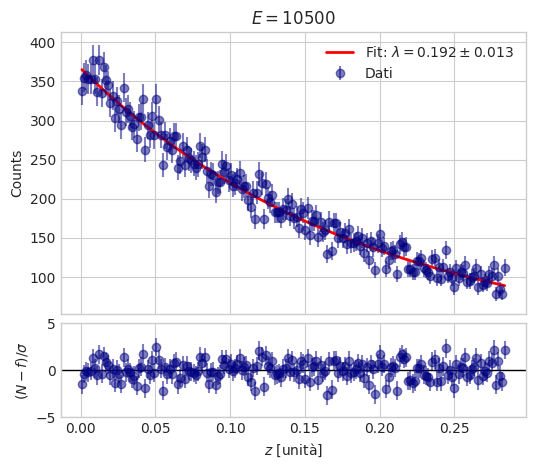

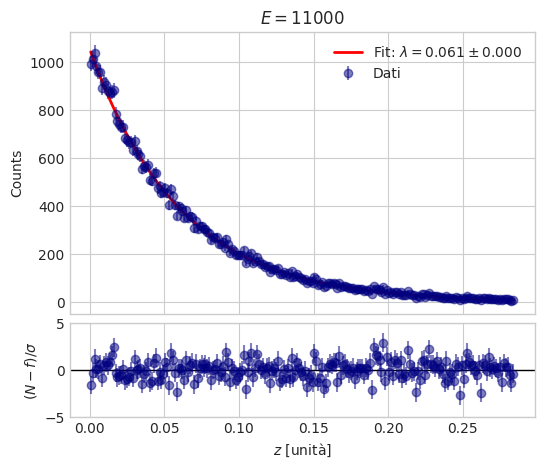

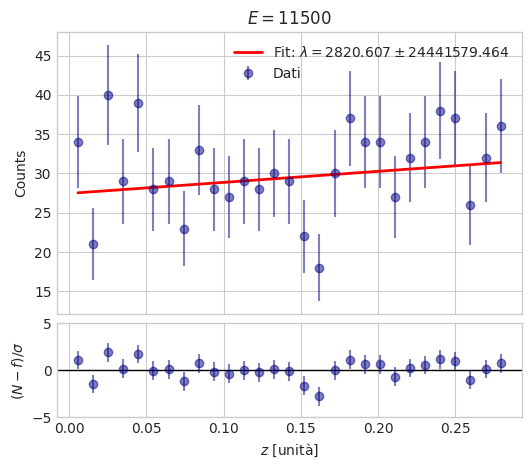

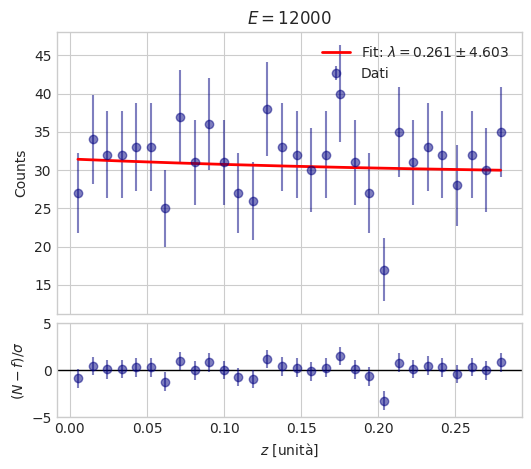

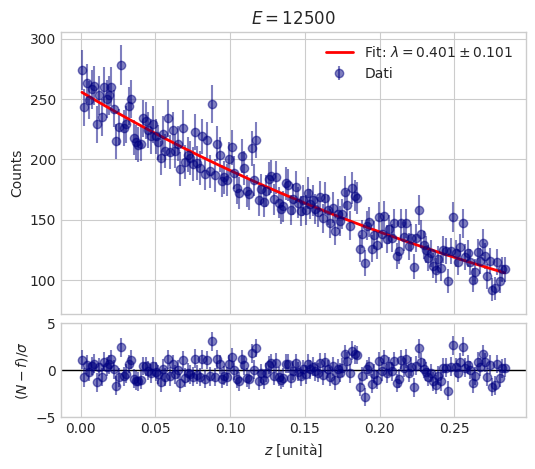

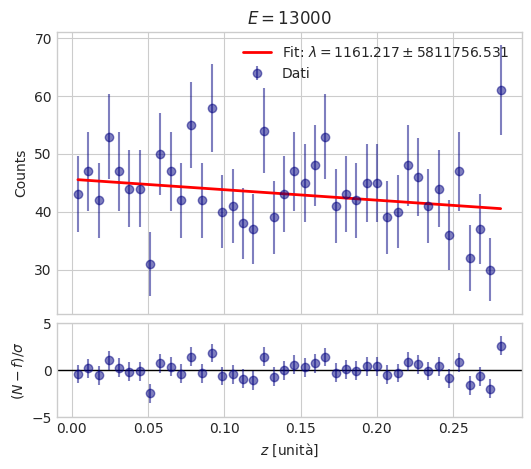

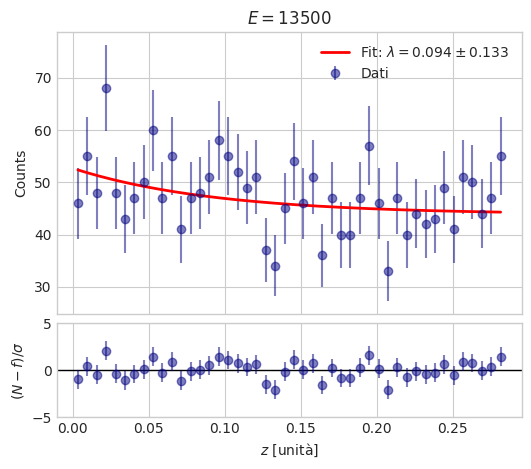

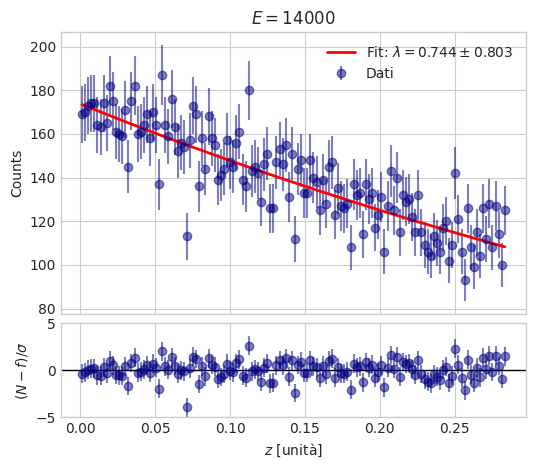

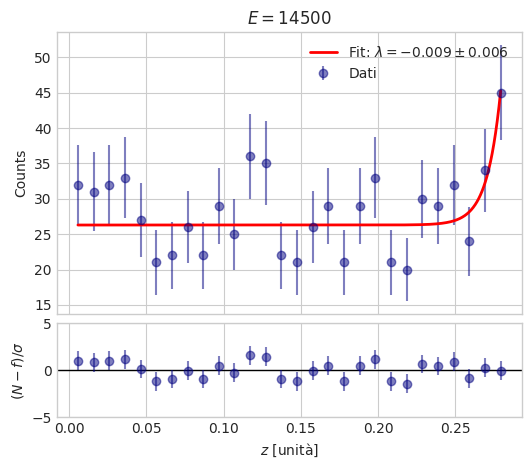

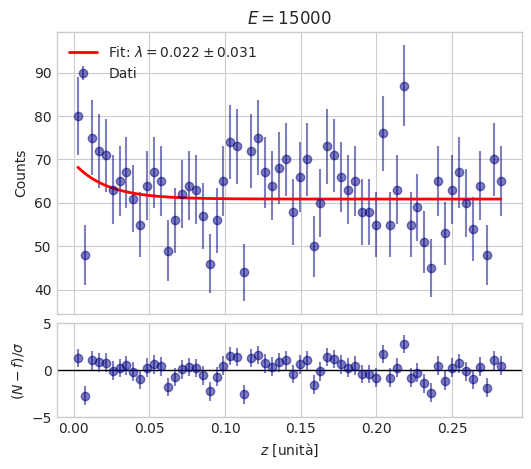

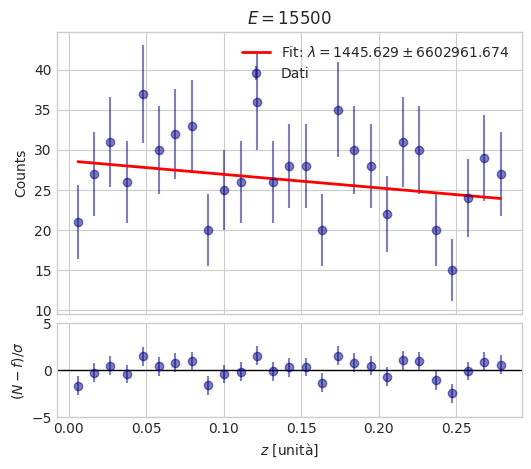

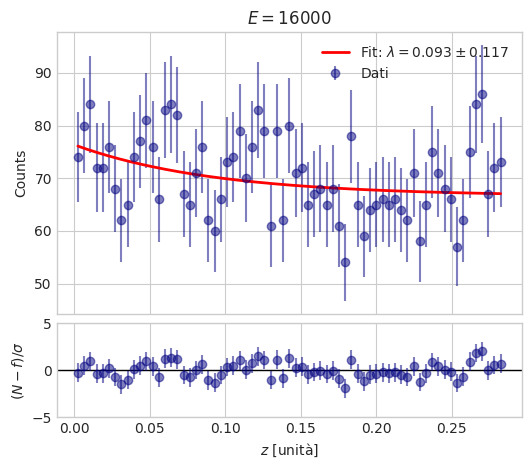

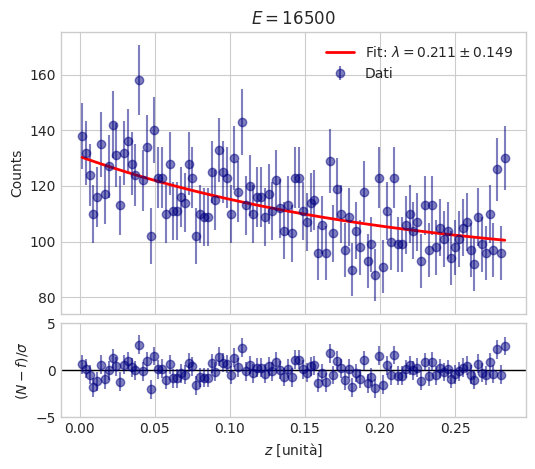

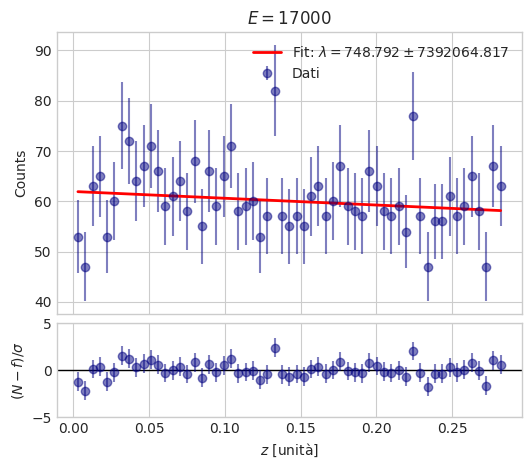

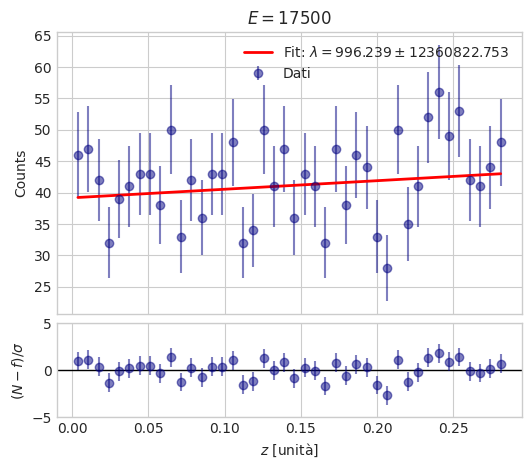

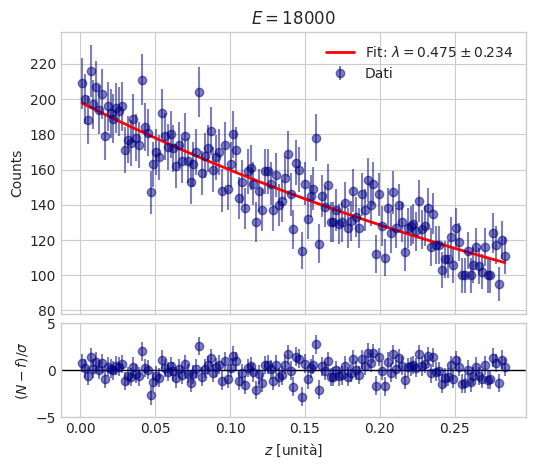

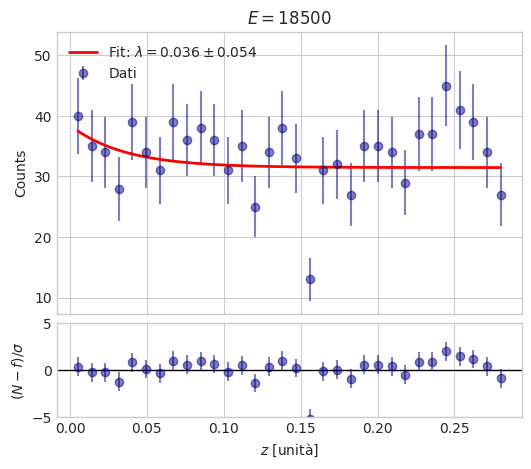

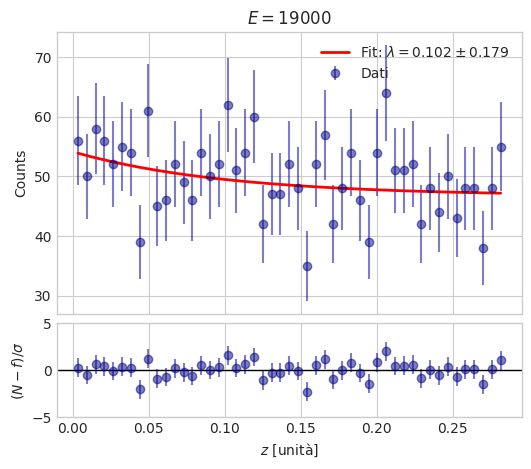

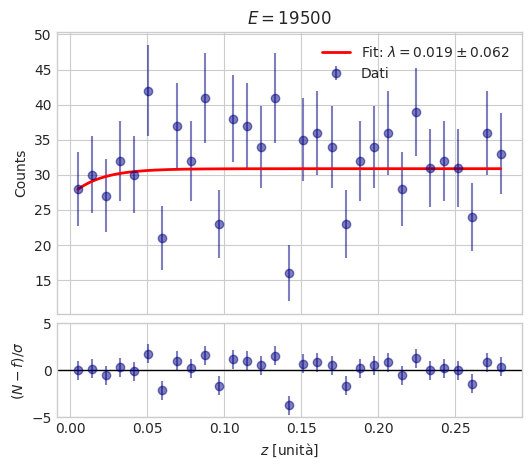

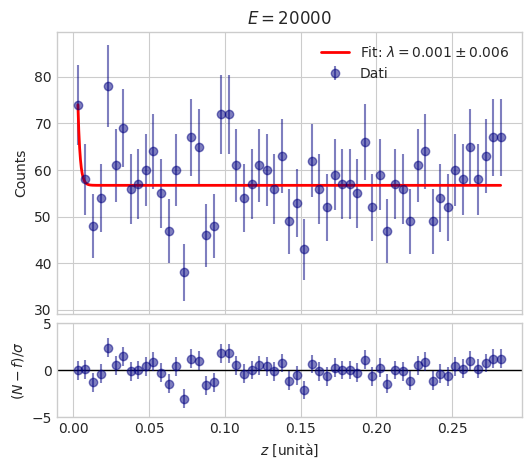

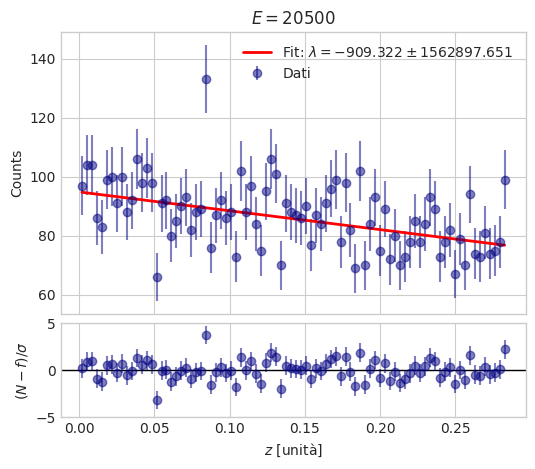

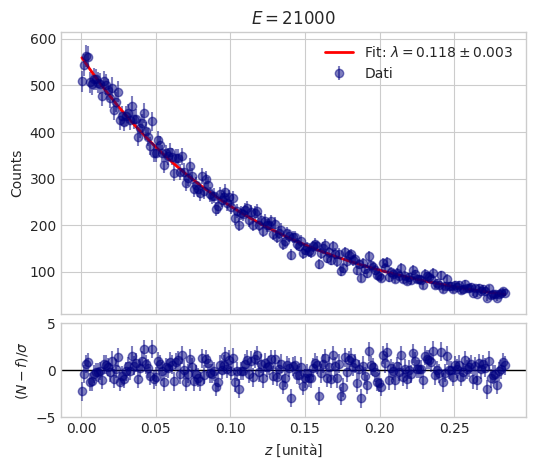

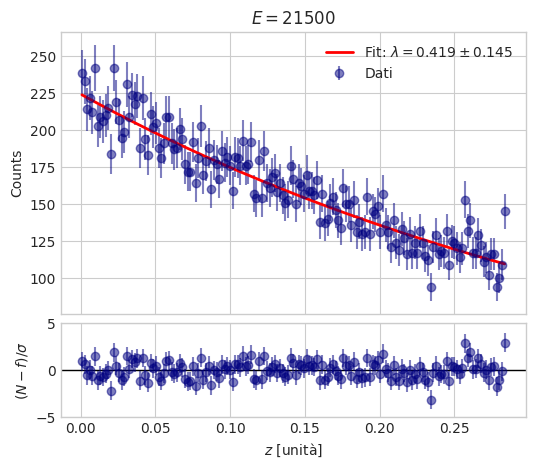

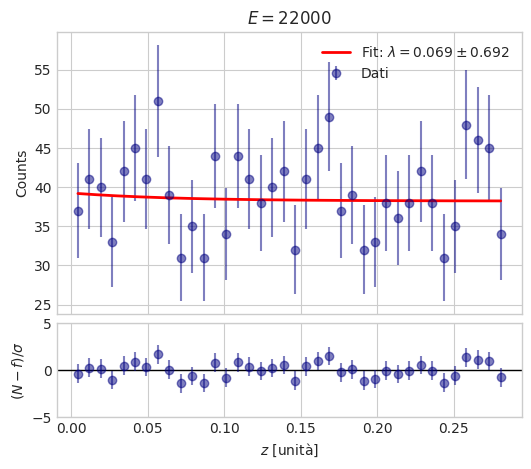

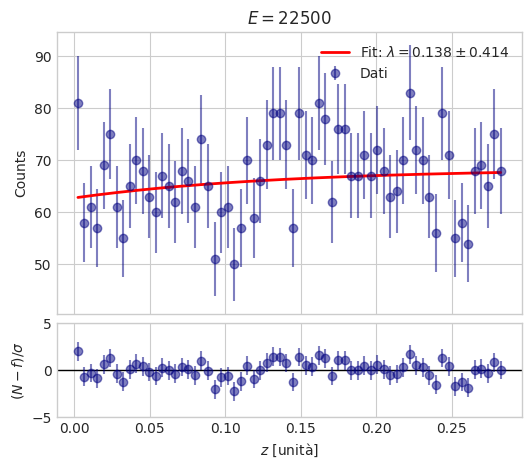

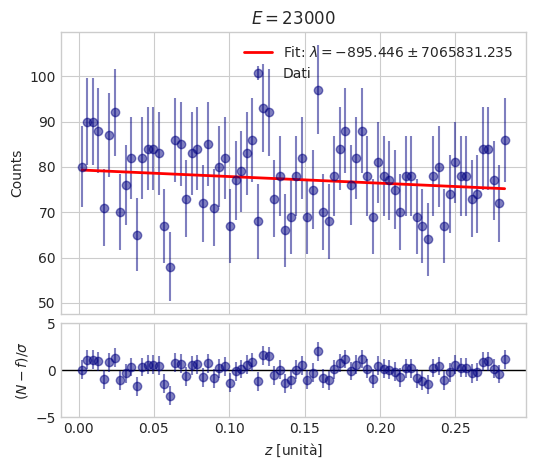

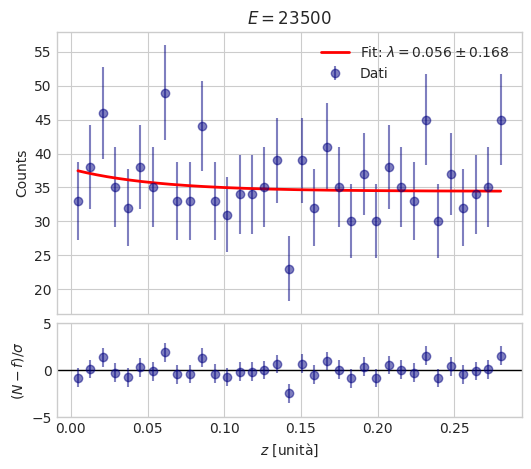

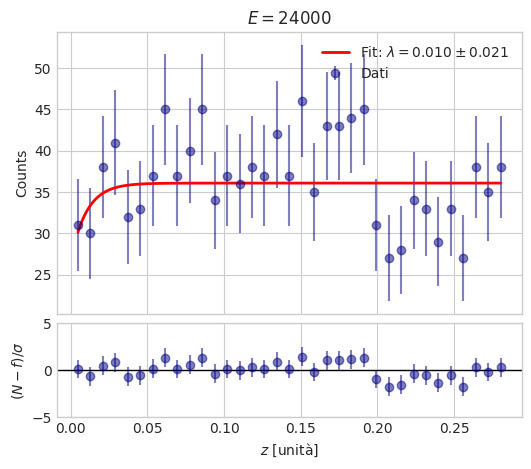

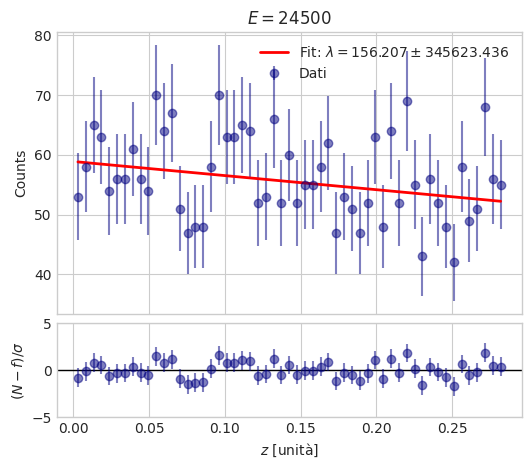

In [6]:
plt.style.use("seaborn-v0_8-whitegrid")
fit_results = {}
for E, z in zip(data["Energy"], data["z"]):

    z = np.asarray(z)

    bins = int(np.sqrt(len(z)))
    counts, edges = np.histogram(z, bins=bins, density=False)
    centers = 0.5 * (edges[1:] + edges[:-1])

    # Errori Poissoniani
    sigma = np.sqrt(counts)
    sigma[sigma == 0] = 1.0   # evita divisioni per zero

    # Guess iniziali
    off_guess = counts[-1]
    A_guess = counts[0] - off_guess
    lambda_guess = 0.1
    p0 = [A_guess, lambda_guess, off_guess]

    try:
        popt, pcov = curve_fit(
            exp_decay,
            centers,
            counts,
            p0=p0,
            sigma=sigma,
            absolute_sigma=True
        )
    except:
        pass

    A, lamb, off = popt
    lamb_err = np.sqrt(pcov[1, 1])
    if (lamb>0 and lamb_err<lamb):
        fit_results[E] = {
        "A": A,
        "lambda": lamb,
        "lambda_err": lamb_err,
        "offset": off
        }

    # Fit
    z_fit = np.linspace(centers.min(), centers.max(), 1000)
    y_fit = exp_decay(z_fit, *popt)

    # Residui normalizzati
    model_counts = exp_decay(centers, *popt)
    residuals = (counts - model_counts) / sigma

    # ================= FIGURA =================
    fig, (ax, ax_res) = plt.subplots(
        2, 1,
        figsize=(6, 5),
        sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # --- Dati + fit ---
    ax.errorbar(
        centers, counts, yerr=sigma,
        fmt="o", color="navy", label="Dati", alpha=0.5
    )
    ax.plot(z_fit, y_fit, "r-", lw=2,
            label=rf"Fit: $\lambda = {lamb:.3f} \pm {lamb_err:.3f}$")

    ax.set_ylabel("Counts")
    ax.set_title(rf"$E = {E}$")
    ax.legend()

    # --- Residui ---
    ax_res.axhline(0, color="k", lw=1)
    ax_res.errorbar(
        centers, residuals, yerr=np.ones_like(residuals),
        fmt="o", color="navy", alpha=0.5
    )

    ax_res.set_ylabel(r"$(N - f)/\sigma$")
    ax_res.set_xlabel(r"$z$ [unità]")
    ax_res.set_ylim(-5, 5)

    plt.tight_layout()
    plt.show()


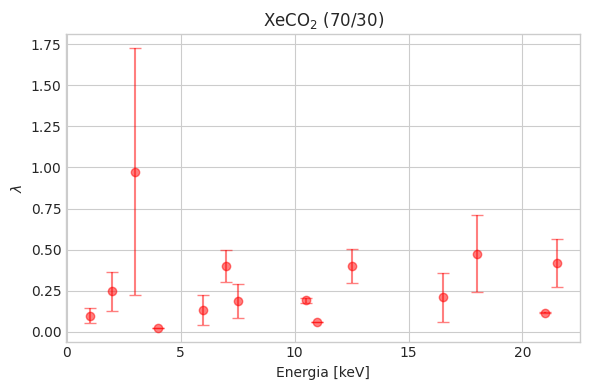

In [7]:
# Ordina per energia
energies = np.array(sorted(fit_results.keys()))
lambdas = np.array([fit_results[E]["lambda"] for E in energies])
lambda_errs = np.array([fit_results[E]["lambda_err"] for E in energies])

en = energies[lambdas < 1]
la = lambdas[lambdas < 1]
le = lambda_errs[lambdas < 1]



plt.figure(figsize=(6,4))
plt.errorbar(
    en[en != 10000]*1e-3,
    la[en != 10000],
    yerr=le[en != 10000],
    fmt="o",
    color="red",
    alpha=0.5,
    capsize=4
)

plt.xlabel("Energia [keV]")
plt.ylabel(r"$\lambda$")
plt.title(r"XeCO$_2$ (70/30)")
plt.grid(which='minor')
plt.tight_layout()
plt.show()

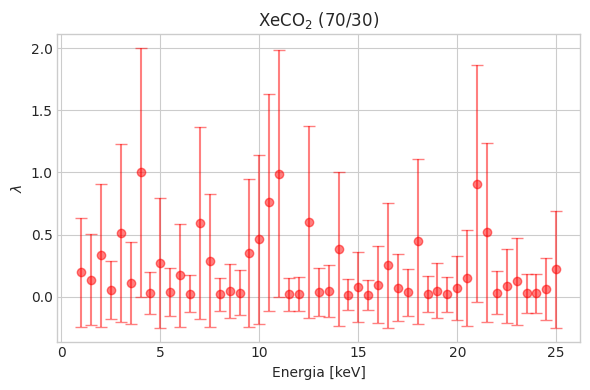

In [8]:
energies = np.arange(1000, 25100, 500)*1e-3
counts = np.array(data["counts"])
counts_errs = np.sqrt(counts)


plt.figure(figsize=(6,4))
plt.errorbar(
    energies,
    counts,
    yerr=counts_errs,
    fmt="o",
    color="red",
    alpha=0.5,
    capsize=4
)

plt.xlabel("Energia [keV]")
plt.ylabel(r"$\lambda$")
plt.title(r"XeCO$_2$ (70/30)")
plt.grid(which='minor')
plt.tight_layout()
plt.show()

In [9]:
np.save("counts_Xe.npy", counts)
np.save("Ecounts_Xe.npy", energies)